# 0.0 Imports

## 0.1 Libraries

In [1]:
import shap
import random
import bisect
import warnings

import numpy             as np
import joblib            as jb
import pandas            as pd
import scipy.stats       as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec     import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn.combine        import SMOTETomek

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier

from skopt                   import forest_minimize
from skopt.plots             import plot_convergence

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix, plot_cumulative_gain, plot_lift_curve

# costomized packages
import sys
sys.path.append('../')

from src.data.make_dataset   import Dataset

## 0.2 Helper Functions

### 0.2.1 Notebook config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [10]:
#========================================= Group Age by an Age Stage =========================================#
def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]

## 0.3 Loading data

In [4]:
dataset = Dataset()

### 0.3.1 Query Train Dataset

In [6]:
df_raw = dataset.get_train_data("../query/raw_data.sql")

# 1.0 Feature Engineering

In [157]:
df02 = df_raw.copy()

In [158]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))


# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}
df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)


# Vehicle Damage
vehicle_damage_mapping = {'No':0,
                          'Yes':1}
df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)


# Vehicle Damage Licence
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2\
    
                                            if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)

# vehicle_damage vs vehicle_age
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2\
                                                if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)


# ratio of age to average age by region
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age


# ratio of age to average age by policy sales channel
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# ratio of annual premmium to average annual premmium by redion
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# ratio of annual premmium to average annual premmium by policy sales channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium



# ratio of age (converted for days) to the vintage
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

In [159]:
df02.dtypes

id                                                              int64
gender                                                         object
age                                                             int64
region_code                                                   float64
policy_sales_channel                                          float64
driving_license                                                 int64
vehicle_age                                                     int64
vehicle_damage                                                  int64
previously_insured                                              int64
annual_premium                                                float64
vintage                                                         int64
response                                                        int64
age_stage                                                      object
vehicle_damage_license                                          int64
vehicle_damage_vehic

In [160]:
########
df02['gender'] = df02['gender'].apply(lambda row: 0 if row == 'Male' else 1)



#customer_term_year
df02['customer_term_year'] = df02['vintage']/365

#insured_gender
df02['insured_gender'] = (100 + 10*df02['previously_insured'] + df02['gender'])/100

#license_insured
df02['license_insured'] = (100 + 10*df02['driving_license'] + df02['previously_insured'])/100

# # oportunity_by_policy_sales_channel (previously_insured)
oportunity_by_policy_sales_channel = pd.DataFrame(df02.groupby('policy_sales_channel')['previously_insured'].mean()).reset_index().rename(columns={'previously_insured': 'oportunity_by_policy_sales_channel'})
oportunity_by_policy_sales_channel['oportunity_by_policy_sales_channel'] = 1 - oportunity_by_policy_sales_channel['oportunity_by_policy_sales_channel']
df02 = pd.merge(df02, oportunity_by_policy_sales_channel, how='left', on='policy_sales_channel')
df02['oportunity_by_policy_sales_channel'] = df02.apply(lambda row: 0.0 if row['previously_insured'] == 1 else row['oportunity_by_policy_sales_channel'], axis=1)
del oportunity_by_policy_sales_channel


# oportunity_by_policy_sales_channel (previously_insured)
oportunity_by_region_code = pd.DataFrame(df02.groupby('region_code')['previously_insured'].mean()).reset_index().rename(columns={'previously_insured': 'oportunity_by_region_code'})
oportunity_by_region_code['oportunity_by_region_code'] = 1 - oportunity_by_region_code['oportunity_by_region_code']
df02 = pd.merge(df02, oportunity_by_region_code, how='left', on='region_code')
df02['oportunity_by_region_code'] = df02.apply(lambda row: 0.0 if row['previously_insured'] == 1 else row['oportunity_by_region_code'], axis=1)
del oportunity_by_region_code


age_stage_vehicle_damage_annual_premium = df02.groupby(['age_stage','vehicle_damage'])['annual_premium'].agg(['mean','std'])
age_stage_vehicle_damage_annual_premium.columns = [x +'_age_damage_premium' for x in age_stage_vehicle_damage_annual_premium.columns.ravel()]
df02 = pd.merge(df02, age_stage_vehicle_damage_annual_premium, on=['age_stage','vehicle_damage'], how='left')



In [163]:
df02.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_stage,vehicle_damage_license,vehicle_damage_vehicle_age,mean_age_by_region_code,age_mean_age_by_region_code,mean_age_by_policy_sales_channel,age_mean_age_by_policy_sales_channel,mean_annual_premium_by_region_code,annual_premium_mean_annual_premium_by_region_code,mean_annual_premium_by_policy_sales_channel,annual_premium_mean_annual_premium_by_policy_sales_channel,age_vintage,customer_term_year,insured_gender,license_insured,oportunity_by_policy_sales_channel,oportunity_by_region_code,mean_age_damage_premium,std_age_damage_premium
0,7,0,23,11.0,152.0,1,0,1,0,23367.0,249,0,Young,4,-1,34.374567,0.669099,26.214825,0.877366,27607.283146,0.846407,30889.192493,0.756478,33.714859,0.682192,1.00,1.10,0.270418,0.380633,28901.718554,16640.308279
1,13,1,41,15.0,14.0,1,1,0,1,31409.0,221,0,Adult,1,1,32.605876,1.257442,53.372990,0.768179,29624.520815,1.060237,33877.260450,0.927141,67.714932,0.605479,1.11,1.11,0.000000,0.000000,28315.221766,17130.780169
2,18,1,25,35.0,152.0,1,0,0,1,46622.0,299,0,Young,1,0,36.135264,0.691845,26.214825,0.953659,26832.931144,1.737492,30889.192493,1.509330,30.518395,0.819178,1.11,1.11,0.000000,0.000000,30757.596017,14271.672103
3,31,1,26,8.0,160.0,1,0,0,0,2630.0,136,0,Young,1,0,38.579567,0.673932,23.435006,1.109451,36467.985241,0.072118,25575.744938,0.102832,69.779412,0.372603,1.01,1.10,0.464255,0.495026,30757.596017,14271.672103
4,39,0,45,8.0,124.0,1,1,1,0,42297.0,264,0,Adult,4,-4,38.579567,1.166421,46.923589,0.959006,36467.985241,1.159839,31710.191162,1.333861,62.215909,0.723288,1.00,1.10,0.714981,0.495026,29480.663310,17915.680540


In [162]:
age_stage_vehicle_damage_annual_premium = df02.groupby(['age_stage','vehicle_damage'])['annual_premium'].agg(['mean','std'])
age_stage_vehicle_damage_annual_premium.columns = [x +'_age_damage_premium' for x in age_stage_vehicle_damage_annual_premium.columns.ravel()]
df02 = pd.merge(df02, age_stage_vehicle_damage_annual_premium, on=['age_stage','vehicle_damage'], how='left')

In [ ]:
###########################################

In [14]:
df3 = df02.copy()

aux1 = df3[df3['response'] == 1 ][['response', 'age']].groupby(['age']).sum().reset_index()

bins = list( np.arange( 20, 90, 5) )
aux2 = aux1
aux2['age_bin'] = pd.cut(aux1['age'], bins=bins)
aux3 = aux2[['response', 'age_bin']].groupby(['age_bin']).sum().reset_index()

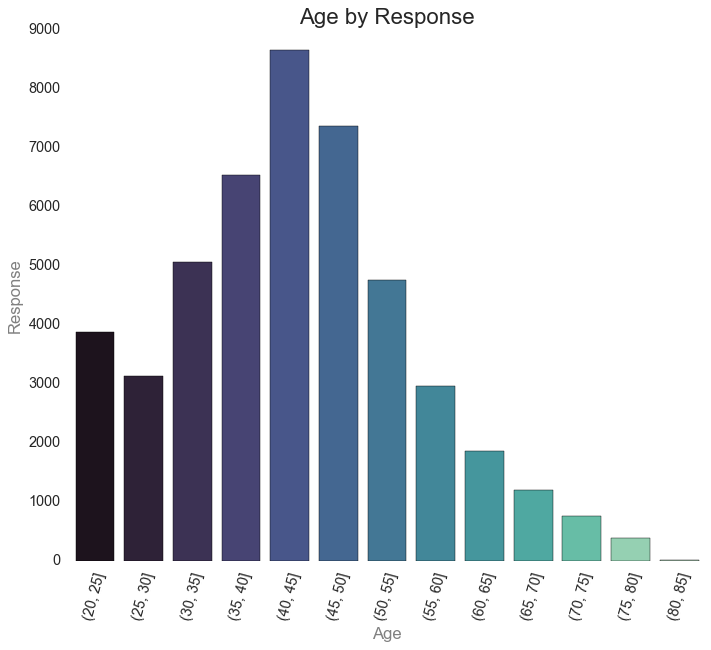

In [48]:
plt.style.use( 'seaborn-bright' );
plt.figure(figsize=(20,8));
plt.subplot(121);
sns.barplot(x='age_bin', y='response', data=aux3, palette='mako');
sns.despine(bottom=True, left=True);
#sns.set_style('whitegrid');
plt.title('Age by Response', size=20);
plt.xlabel('Age', color='grey', size=15);
plt.ylabel('Response', color='grey', size=15);
plt.xticks(rotation=75);